In [1]:
import pickle
import pandas as pd
import numpy as np

## 1. Load Dataset 

In [4]:
X_train = pd.read_csv('./label_syn/encoding_train.csv', encoding='utf-8-sig')
X_valid = pd.read_csv('./label_syn/encoding_valid.csv', encoding='utf-8-sig')

In [5]:
y_train= pd.read_csv('./label_syn/y_train.csv', encoding='utf-8-sig')
y_valid= pd.read_csv('./label_syn/y_valid.csv', encoding='utf-8-sig')

## 1_2 Load Dataset  & Feature Importance 반영

In [9]:
X_train.columns

Index(['신고세관부호', '수입신고구분코드', '수입거래구분코드', '수입종류코드', '징수형태코드', '운송수단유형코드',
       '신고인부호', '수입자', '해외거래처부호', '특송업체부호', 'HS10단위부호', '적출국가코드', '원산지국가코드',
       '관세율', '관세율구분코드', '원산지표시유무코드', '신고중량(KG)', '과세가격원화금액'],
      dtype='object')

## 2. Over sampling

In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
over_sampler = RandomOverSampler(random_state = 11)
X_train_over,y_train_over = over_sampler.fit_resample(X_train,y_train)
print('Oversampler 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('Oversampler 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('Oversampler 적용 후 레이블 값 분포: \n', y_train_over.value_counts())

Oversampler 적용 전 학습용 피처/레이블 데이터 세트:  (36592, 18) (36592, 1)
Oversampler 적용 후 학습용 피처/레이블 데이터 세트:  (57484, 18) (57484, 1)
Oversampler 적용 후 레이블 값 분포: 
 우범여부
0       28742
1       28742
dtype: int64


In [14]:
over_sampler = RandomOverSampler(random_state = 11)
X_valid_over,y_valid_over = over_sampler.fit_resample(X_valid,y_valid)
print('Oversampler 적용 전 학습용 피처/레이블 데이터 세트: ', X_valid.shape, y_train.shape)
print('Oversampler 적용 후 학습용 피처/레이블 데이터 세트: ', X_valid_over.shape, y_valid_over.shape)
print('Oversampler 적용 후 레이블 값 분포: \n', y_valid_over.value_counts())

Oversampler 적용 전 학습용 피처/레이블 데이터 세트:  (8480, 18) (36592, 1)
Oversampler 적용 후 학습용 피처/레이블 데이터 세트:  (13314, 18) (13314, 1)
Oversampler 적용 후 레이블 값 분포: 
 우범여부
0       6657
1       6657
dtype: int64


## 3. xgboost

In [16]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [17]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [18]:
from scipy import stats

In [19]:
xgb = XGBClassifier()#objective=' binary:logistic',
                    #metric='binary',
                    #eval_metric='logloss',
                    #nthread=1)

# A parameter grid for XGBoost
params = {'n_estimators': stats.randint(150, 1000),
          'learning_rate': stats.uniform(0.01, 0.6),
          'min_child_weight': [1, 2, 3, 4, 5],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]
        }
folds = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params,
                                   n_iter=5, # you want 5 here not 25 if I understand you correctly 
                                   scoring='roc_auc',
                                   n_jobs=1,                                   
                                   cv=skf.split(X_train_over, y_train_over),
                                   verbose=3,
                                   random_state=1001 )

# Here we go
start_time = timer(None) 
random_search.fit(X_train_over, y_train_over)
timer(start_time) 

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8 
[17:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8, score=0.887, total=   3.2s
[CV] colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8 
[17:35:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8, score=0.880, total=   3.1s
[CV] colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8 
[17:36:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=1, learning_rate=0.16903813936450346, max_depth=5, min_child_weight=4, n_estimators=420, subsample=0.8, score=0.879, total=   3.7s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.14394521160744317, max_depth=5, min_child_weight=5, n_estimators=398, subsample=0.6 
[17:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.6, gamma=5, learning_rate=0.14394521160744317, max_depth=5, min_child_weight=5, n_estimators=398, subsample=0.6, score=0.838, total=   3.5s
[CV] colsample_bytree=0.6, gamma=5, learning_rate=0.14394521160744317, max_depth=5, min_child_weight=5, n_estimators=398, subsample=0.6 
[17:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/l

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   53.2s finished



 Time taken: 0 hours 0 minutes and 56.31 seconds.


## 3. 모델학습

### 3.1 학습/테스트 데이터 학습(xgboost) 성능

In [20]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval2(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("오차행렬\n", confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
    
# 모델 학습 함수
def get_model_train_eval2(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval2(tgt_test, pred, pred_proba)

In [25]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5994130001745845, max_delta_step=0, max_depth=4,
              min_child_weight=2, monotone_constraints='()',
              n_estimators=424, n_jobs=20, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None, objective= 'binary:logistic', eval_metric='logloss')

In [26]:
start_time = timer(None) 
get_model_train_eval2(xgb_model, ftr_train = X_train_over, ftr_test = X_valid_over, 
                      tgt_train = y_train_over, tgt_test = y_valid_over)
timer(start_time) 

오차행렬
 [[5509 1148]
 [3361 3296]]
정확도: 0.6613, 정밀도: 0.6814, 재현율: 0.6613, F1:0.6517


 Time taken: 0 hours 0 minutes and 2.2 seconds.


## 5. 모델 저장

In [31]:
import pickle
file_name = "./model_syn/xgb_reg.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# load
new_xgb_model = pickle.load(open(file_name, "rb"))

### 3.2 기존 학습(xgboost) 모델을 가져와서 검증

In [32]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval2(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("오차행렬\n", confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
    
# 모델 학습 함수
def get_model_train_eval2(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval2(tgt_test, pred, pred_proba)

In [33]:
# 모델 불러오기
file_name = "./model_syn/xgb_reg.pkl"

# load
w_xgb_model = pickle.load(open(file_name, "rb"))

In [35]:
# predict, predict_proba 추출

w_preds = w_xgb_model.predict(X_valid_over)
w_pred_proba = w_xgb_model.predict_proba(X_valid_over)[:,1]

In [36]:
# get_clf_eval()를 이용해 사키릿런 래퍼 XGBoost로 만들어진 모델 예측 성능 평가

get_clf_eval2(y_valid_over, w_preds, w_pred_proba)

오차행렬
 [[5509 1148]
 [3361 3296]]
정확도: 0.6613, 정밀도: 0.6814, 재현율: 0.6613, F1:0.6517



## 4. Feature Importance (사이킷 런 xgboost)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

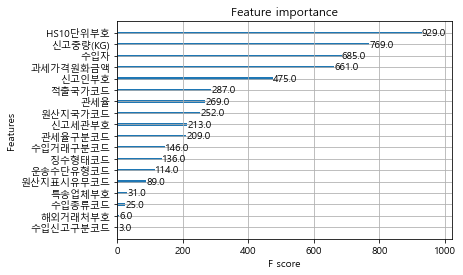

In [37]:
%matplotlib inline
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20)

In [40]:
import eli5 
from eli5.sklearn import PermutationImportance 
perm = PermutationImportance(xgb_model, scoring = "accuracy", random_state = 22).fit(X_valid_over, y_valid_over) 
eli5.show_weights(perm, top = 20, feature_names = X_valid_over.columns.tolist())

## 6. 실제 /예측값 비교

In [41]:
X_org = pd.read_csv('./label_syn/df_enc_valid.csv', encoding='utf-8-sig')

In [44]:
pred_critical = w_xgb_model.predict(X_valid)

In [45]:
a = np.array([pred_critical])
pred_df = pd.DataFrame({'우범여부_예측':a[0]})
pred_df

우범여부_예측
0           0
1           0
2           0
3           0
4           0
...       ...
8475        1
8476        1
8477        0
8478        0
8479        1

[8480 rows x 1 columns]

In [46]:
sample=X_org[['신고세관부호','신고인부호','수입자','HS10단위부호','우범여부']]

In [47]:
dfa = pd.DataFrame(sample)
final_df = dfa.join(pred_df)
final_df

신고세관부호    신고인부호      수입자    HS10단위부호  우범여부  우범여부_예측
0         13  L77JJEG  HQ0W7JA  8407210000     0        0
1         20  749ECRU  Y2FJ95S  8479909070     0        0
2         19  OZB7KED  446O4EE  6211111000     0        0
3         31  SM89FYN  OOWNJY9  8207191000     1        0
4         20  DM8H44I  MU3B4MR  3304999000     0        0
...      ...      ...      ...         ...   ...      ...
8475      39  6D4DNS7  8TW53B3  6907210000     0        1
8476      40  3BTA0QN  USP5TV1  4911100000     1        1
8477      13  NULLLLS  XE08QFH  8530900000     1        0
8478      41  KWSE1HX  JUJJ961  1207400000     0        0
8479      22  6T0AJ3G  6P2UOTH  9027801000     1        1

[8480 rows x 6 columns]

In [49]:
# 파일 저장 #
final_df.to_csv('./label_syn/predict_evaluation.csv', index=None, encoding='949')